# Demonstration of Dynamic Simulation (Control stability of aggressive volt-var setting)

This example demonstrates how to use OpenDER to conduct a dynamic simulation to evaluate control stability that may occur in a weak grid condition, when aggressive volt-var setting is configured.

In [1]:
import numpy as np
from opender_interface import DERInterface, OpenDSSInterface, XYPlots, TimePlots, CombinedTimePlots
from opender import DER, DER_PV, DERCommonFileFormat

# configure the dynamic simulation
delt = 0.01  # sampling time step (s)
DER.t_s = delt
vbase = 12.47e3
sbase = 1e6
zbase = vbase ** 2 / sbase

The control stability is related to the dynamic performance of the volt-var control. IEEE 1547-2018 defines the open loop response time (OLRT) as *the duration from a step change in control signal input (reference value or system quantity) until the output changes by 90% of its final change, before any overshoot*. For volt-var control, the default value is 5 seconds, and the range of allowable setting is 1s to 90s.
In this example, the OLRT is set to 1s, as the most aggressive setting. In addition, a reaction time of 0.2 second is assumed.
The volt-var curve is set to the most aggressive settings as well.

In [2]:
der_obj1 = DER_PV(QV_MODE_ENABLE=True, QV_CURVE_V2=1, QV_CURVE_V3=1, QV_CURVE_V1=0.98, QV_CURVE_V4=1.02, QV_OLRT=1)
der_obj2 = DER_PV(QV_MODE_ENABLE=True, QV_CURVE_V2=1, QV_CURVE_V3=1, QV_CURVE_V1=0.98, QV_CURVE_V4=1.02, QV_OLRT=1)
der_obj2.der_file.NP_REACT_TIME = 0.2


The following shows the volt-var curve.

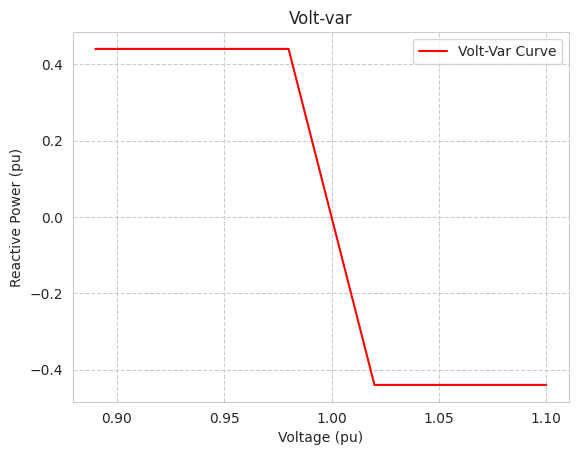

In [3]:
xyplot = XYPlots(der_obj1)
xyplot.prepare_vq_plot()
xyplot.show()

The following shows the time response of the volt-var function simulated under an infinite bus after a voltage step change at 1s.
* The first case has no reaction time. The reactive power starts to change immediately after the voltage changes.
* The second case has a 0.2s reaction time. The reactive power stays at 0 for 0.2s after
* Both traces has the OLRT set to be 1s. Both reactive powers reach 0.4pu (90% of 0.44pu) at 2s.

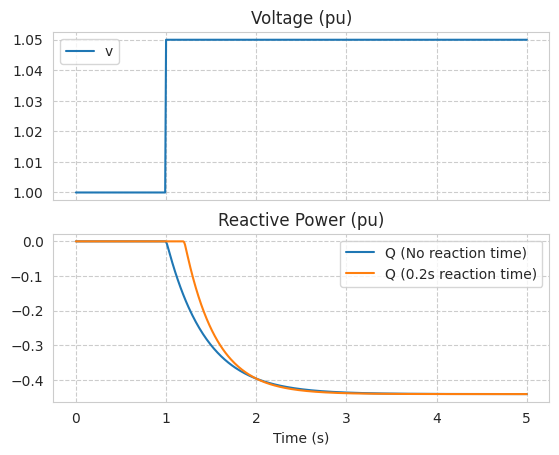

In [4]:
tplot = TimePlots(2,1, ['Voltage (pu)', 'Reactive Power (pu)'])
t = 0
while t < 5:
    if t < 1:
        v = 1
    else:
        v = 1.05
    der_obj1.update_der_input(f=60, v_pu=v, p_dc_pu=0.5)
    der_obj2.update_der_input(f=60, v_pu=v, p_dc_pu=0.5)

    der_obj1.run()
    der_obj2.run()
    tplot.add_to_traces(
        {
            'v': v
        },
        {
            'Q (No reaction time)': der_obj1.der_output.q_out_pu,
            'Q (0.2s reaction time)': der_obj2.der_output.q_out_pu
        }
    )
    t=t+delt
tplot.prepare()
tplot.axes[1].legend(loc=1)
tplot.axes[0].grid()
tplot.axes[1].grid()
tplot.show()

Now, instead of an infinite bus, the control stability is demonstrated in a weak grid. The simplified test circuit only includes a voltage source, a DER, and a line impedance in between. The X/R ratio is 5, and the short circuit ratio is 5. So the impedance is 0.2 pu.

In [5]:
# configure distribution circuit line parameters
xor1 = 5
zpu1 = 0.2

rpu1 = zpu1 / np.sqrt(1 + xor1 ** 2)
xpu1 = rpu1 * xor1
rohms1 = rpu1 * zbase
xohms1 = xpu1 * zbase

Simulate for two scenarios. The first case has the OLRT set to 5s, and the second case has the OLRT set to 1s

In [6]:
# circuit configuration
dss_interface = OpenDSSInterface()
# create 2 OpenDER interfaces for the 2 simulation cases
ckt_int_list = [DERInterface(dss_interface, t_s=delt, print_der=False) for i in range(2)]

# create DER objects for the 2 simulation cases
derfiles = [DERCommonFileFormat(NP_P_MAX=sbase, NP_VA_MAX=sbase, NP_Q_MAX_INJ=sbase, NP_Q_MAX_ABS=sbase, NP_Q_CAPABILITY_LOW_P="SAME",
                                QV_MODE_ENABLE=True, QV_CURVE_V2=1, QV_CURVE_V3=1, QV_CURVE_V1=0.98, QV_CURVE_V4=1.02, NP_REACT_TIME = 0.2) 
            for i in range(2)]

derfiles[1].QV_OLRT = 1

In [7]:
der_list = []
plot_list = []

In [8]:
for i, ckt_int in enumerate(ckt_int_list):
    ckt_int.cmd(["Clear",
                 "New Circuit.ckt1 pu=1.00  r1=0.001  x1=0.001  r0=0.001 x0=0.001  bus1= sub_src basekv = 12.47",
                 f"New line.line1 bus1=sub_src  bus2=der  r1={rohms1} x1={xohms1} r0={rohms1} x0={xohms1} phases=3  enabled=true",
                 "New PVSystem.PV1 Bus1=der.1.2.3 Phases=3, kV=12.47 Pmpp=5000 kVA=5000 irradiance=1 kvarMax=2200.0 kvarMaxAbs=-2200.0 PFpriority=Yes pf=1 vminpu=0.1 irradiance = 1 %cutin=0.00001, %cutout=0.0000001",
                 "Calcv",
                 "solve",
                 "compile"])

    ckt_int.initialize(DER_sim_type='PVsystem')

    # create OpenDER objects
    P_gen = 0
    der_list.append(ckt_int.create_opender_objs(derfiles[i], p_pu=P_gen))
    ckt_int.der_convergence_process()
    # create time-series plot object
    plot_obj = TimePlots(2, 1)
    plot_list.append(plot_obj)

    # run time series simulation for 800s
    for t in range(int(10/delt)):

        # Power ramp from 0 to 1 in 30s
        if t > 1/delt:
            ckt_int.set_source_voltage(1.05)
        #     P_gen = min(1.0, P_gen+1/30*delt)
        #
        # ckt_int.update_der_p_pu([P_gen])

        # Obtain system voltage from previous power flow solution
        ckt_int.read_sys_voltage()
        # Simulate DER dynamics
        ckt_int.run()
        # Update DER outputs to circuit simulation
        ckt_int.update_der_output_powers()
        # set the new tap position into opendss
        ckt_int.solve_power_flow()

        # Save simulation results to time series plot for future plots
        plot_obj.add_to_traces(
            {
                f'v (OLRT = {der_list[i][0].der_file.QV_OLRT})': sum(list(ckt_int.ckt.buses.loc['der', ['Vpu_A', 'Vpu_B', 'Vpu_C']]))/3,
            },
            {
                f'Q (OLRT = {der_list[i][0].der_file.QV_OLRT})': der_list[i][0].q_out_pu,
            },
        )

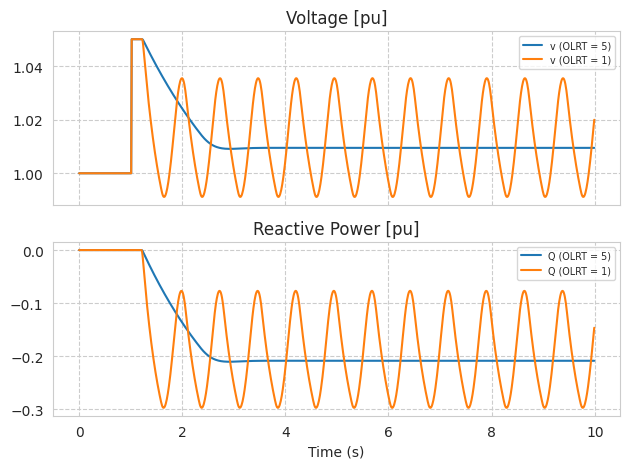

In [9]:
combined = CombinedTimePlots(2,1, ['Voltage [pu]', 'Reactive Power [pu]'])
combined.combine_time_plots(plot_list)
combined.prepare()
for ax in combined.axes:
    ax.legend(fontsize='x-small')
    ax.grid()
combined.fig.tight_layout()
combined.show()

The simulated event is initiated by increasing the voltage source setpoint from 1.00pu to 1.05pu.

As can be seen, the system is stable when OLRT is 5s, and oscillates when OLRT is 1s.

Typically, if using default IEEE 1547-2018 volt-var setting, the concern of control stability is minimal.
The control stability of volt-var control is related to:
* Grid strength (SCR or line impedance)
* Volt-var curve setting
* Open loop response time (OLRT) setting
* Reaction time of the volt-var time response.